### Introducción
El objetivo final de este proyecto es predecir el sentimiento de un texto dado usando python, donde usamos NLTK, también conocido como Natural Language Processing Toolkit.

* Para este proyecto, importaremos un conjunto de librerías que se muestran a continuación
* Importaremos el conjunto de datos
* Realizaremos limpieza, formateo y visualización de los datos
* Construcción del modelo
* Predicción

In [312]:
# Importar librerías
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import requests
import string as st

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [6]:
# Importar datos
data = pd.read_csv('../DatosOriginales/reviews_filmaffinity.csv', delimiter='|', header=0)

In [7]:
data.shape

(8591, 6)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8591 entries, 0 to 8590
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   film_name      8591 non-null   object 
 1   gender         8591 non-null   object 
 2   film_avg_rate  8591 non-null   object 
 3   review_rate    8589 non-null   float64
 4   review_title   8591 non-null   object 
 5   review_text    8591 non-null   object 
dtypes: float64(1), object(5)
memory usage: 402.8+ KB


In [9]:
data.head()

,film_name,gender,film_avg_rate,review_rate,review_title,review_text
0,Ocho apellidos vascos,Comedia,"6,0",3.0,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...
1,Ocho apellidos vascos,Comedia,"6,0",2.0,El perro verde,"No soy un experto cinéfilo, pero pocas veces m..."
2,Ocho apellidos vascos,Comedia,"6,0",2.0,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...
3,Ocho apellidos vascos,Comedia,"6,0",2.0,Aida: The movie,"No sé qué está pasando, si la gente se deja ll..."
4,Ocho apellidos vascos,Comedia,"6,0",2.0,UN HOMBRE SOLO (Julio Iglesias 1987),"Pero cuando amanece,y me quedo solo,siento en ..."


In [10]:
# Encontrar nulos
data.isnull().sum()

film_name        0
gender           0
film_avg_rate    0
review_rate      2
review_title     0
review_text      0
dtype: int64

In [11]:
# Eliminar nulos
data=data.dropna()

In [12]:
# Comprobando datos de la columna y noto que los valores contienen una coma y además son objetos. 
film=data['film_avg_rate'].unique()
print(film)


['6,0' '6,8' '4,4' '6,7' '4,8' '5,3' '6,5' '6,4' '7,2' '4,2' '6,9' '3,7'
 '5,7' '5,5' '7,7' '6,1' '5,8' '5,2' '5,4' '4,6' '5,0' '7,1' '3,9' '4,7'
 '5,1' '6,2' '6,6' '7,0']


In [13]:
# La columna film_avg_rate La convierto en float y remplazo ',' por '.'
data['film_avg_rate'] = data['film_avg_rate'].str.replace(',', '.').astype(float)


In [14]:
# comprobar rango de puntajes en la columna review_rate
rate=data['review_rate'].unique()
print(rate)

[ 3.  2.  8.  1.  6.  4.  5.  7.  9. 10.]


In [19]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
film_avg_rate,8589.0,6.186972,0.991661,3.7,5.5,6.5,6.9,7.7
review_rate,8589.0,5.872744,2.549188,1.0,4.0,6.0,8.0,10.0


Crear una escala más manejable de los valores de review_rate en el que agruparemos siguiendo el criterio de normalidad que nos muestra la descripción de la tabla el 25 % de los puntajes estan entre 1-4, con lo cual los agrupamos con el puntaje 0 = 1,2,3,4 y los significamos como valores negativos. entre el 25% y el 75% se ubican los puntajes entre  5-8 y los agrupamos con el puntaje 1 = 5,6,7, significandolos neutrales y por encima del 75% los puntajes 9,10 que agrupamos en el puntaje 2 = 8,9,10 como positivos.

In [20]:
# Valoración calificaciones 

def clasificar_rate(n_review):
    if (n_review <= 4.0).all():
        return 'Negative'
    elif ((n_review > 4.0) & (n_review <= 7.0)).any():
        return 'Neutral'
    else:
        return 'Positive'
    
data['value_rate']= data.groupby(level=0)['review_rate'].apply(lambda x: clasificar_rate(x))

In [21]:
data.sample(5)

,film_name,gender,film_avg_rate,review_rate,review_title,review_text,value_rate
6030,Es por tu bien,Comedia,5.1,2.0,Venezuela,"Los cuarentones y cincuentones sobran, el pate...",Negative
1081,El orfanato,Terror,6.7,4.0,La Orfanatitis,Enfermedad del hombre y de pocas especies anim...,Negative
7230,Los crímenes de Oxford,Intriga,5.7,6.0,De re-listos gafapasta con un pezoncillo muy e...,"Me esperaba un absoluto desprósito, pero a Ale...",Neutral
3337,Palmeras en la nieve,Drama,6.0,3.0,plana,Ante lo que podría haber sido una gran películ...,Negative
7364,REC,Terror,6.6,5.0,"Original y entretenida, pero facil de hacer.",La película tiene una historia bastante origin...,Neutral


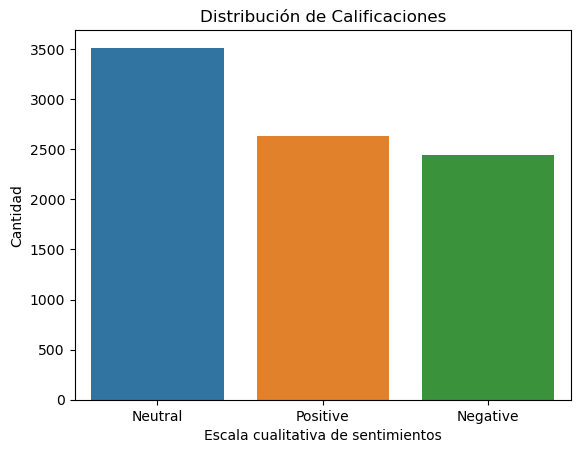

In [56]:
# Obtener la frecuencia de cada categoría
category_counts = data['value_rate'].value_counts()

# Crear el gráfico de barras
sns.barplot(x=category_counts.index, y=category_counts.values)

# Colores para las barras
colors = ['red', 'green', 'blue']

# Configurar los ejes y el título del gráfico

plt.xlabel('Escala cualitativa de sentimientos')
plt.ylabel('Cantidad')
plt.title('Distribución de Calificaciones')

# Mostrar gráfico
plt.show()

In [23]:
#Simplificación de sentimientos
a=[]
for i, review_rate in enumerate(data['review_rate']):
    if review_rate <= 4.0:
        a.append(0)
    elif review_rate <= 7.0:
        a.append(1)
    elif review_rate > 7.0:
        a.append(2)
    else:
        print(f"Unmatched value at index {i}: {review_rate}")


        

In [24]:
a = [int(value) for value in a]

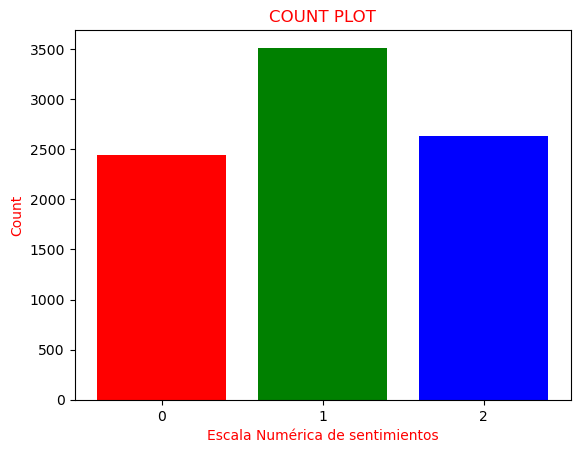

In [50]:
#Graficamos solo con matplotlib.pyplot porque seaborn esta dando un error

# Contar la frecuencia de cada categoría en 'a'
counts = [a.count(0), a.count(1), a.count(2)]

# Etiquetas de las categorías
labels = ['0', '1', '2']

# Colores para las barras
colors = ['red', 'green', 'blue']

# Crear el gráfico de barras con colores diferentes
plt.bar(labels, counts, color=colors)
plt.xlabel('Escala Numérica de sentimientos', color="red")
plt.ylabel('Count', color="red")
plt.title('COUNT PLOT', color="r")
plt.show()

In [26]:
data['sentiment']=a
final_dataset = data[['review_text', 'sentiment']]
print(final_dataset)

                                            review_text  sentiment
0     La mayor virtud de esta película es su existen...          0
1     No soy un experto cinéfilo, pero pocas veces m...          0
2     Si no eres un incondicional del humor estilo T...          0
3     No sé qué está pasando, si la gente se deja ll...          0
4     Pero cuando amanece,y me quedo solo,siento en ...          0
...                                                 ...        ...
8586  Buena no, lo siguiente. Por fin un film serio ...          2
8587  Me esperaba mucho, pero que mucho, más.Guión m...          0
8588  De mal cuerpo como sensación al finalizar, de ...          0
8589  Los que han añadido comentarios os lo han dich...          0
8590  Fui a ver esta película de cine con entusiasmo...          0

[8589 rows x 2 columns]


In [27]:
#Cuento cantidad de comentarios

data_p=final_dataset[data['sentiment']==2]
data_n=final_dataset[data['sentiment']==0]
len(data_n), len(data_p)

(2440, 2635)

In [28]:
#Selecciono la misma cantidad de comentarios positivos y negativos

datap = data_p.iloc[np.random.randint(0, len(data_p), 2400), :]
datan = data_n.iloc[np.random.randint(0, len(data_n), 2400), :]

len(datan), len(datap)

(2400, 2400)

In [29]:
# creo nuevo dataset con datos equivalentes para el modelo

data_sent = pd.concat([datap,datan])
len(data_sent)

4800

In [30]:
data_sent.sample()

,review_text,sentiment
7163,Complicada película donde el tema principal so...,2


In [31]:
# En una nueva variable asigno 0 a los valores negativos y 1 a los valores positivos.
c=[]
for i in data_sent['sentiment']:
    if i==2:
        c.append(1)
    if i==0:
        c.append(0)
data_sent['sentiment']=c

In [32]:
data_sent.sample(10)

,review_text,sentiment
1097,Nuestro cine patrio se caracteriza por muchas ...,0
7571,"Con un punto de vista cámara en mano, la pelíc...",1
2567,Haceos un favor. Ved la extraordinaria Mi pie ...,0
7376,Me ha impresionado esta peli. Y creo que si es...,1
3785,Por muy bien lograda que esté la ambientación ...,0
7539,"Original,distinta; inquietante e inteligente c...",1
5575,"De no ser por el reparto tan ""Almodoriano"", si...",1
972,Copia practicamente a la primera pelicula haci...,0
2644,Cuando salió Torrente: el brazo tonto de la le...,0
3641,Qué lástima. Podría haber sido una gran pelícu...,0


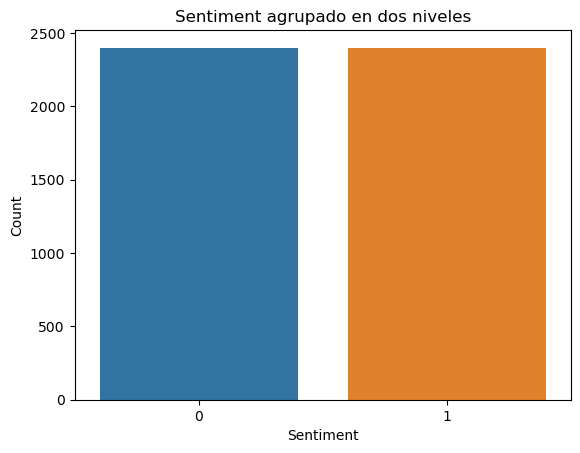

In [33]:
# Visualizar
sns.countplot(data=data_sent, x='sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment agrupado en dos niveles')
plt.show()

## Construcción del modelo

In [34]:
data_sent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 6283 to 3641
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  4800 non-null   object
 1   sentiment    4800 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 112.5+ KB


In [35]:
# Eliminar signos
def punc_clean(text):
    punctuation = ''.join([c for c in st.punctuation if c != '´'])
    a = [w for w in text if w not in punctuation]
    return ''.join(a)

data_sent['review_text'] = data_sent['review_text'].apply(punc_clean)


In [36]:
data_sent.head()

,review_text,sentiment
6283,Alejandro Amenábar era para mí un director un ...,1
2475,Lección de vida aunque parezca que no Lección ...,1
838,ArgumentoDiciembre del año 2004 María Naomi Wa...,1
4019,No puedo añadir algo que no se haya dichoSimpl...,1
6446,Bellísima a rabiarHistoria llena de realidades...,1


In [37]:
# Eliminar palabras vacías
def remove_stopwords(text):
    stopword=nltk.corpus.stopwords.words('spanish')
    stopword.remove('no')
    a=[w for w in nltk.wordpunct_tokenize(text) if w not in stopword]
    return ' '.join(a)
data_sent['review_text'] = data_sent['review_text'].apply(remove_stopwords)

In [38]:
data_sent.head()

,review_text,sentiment
6283,Alejandro Amenábar director irregular Me encan...,1
2475,Lección vida aunque parezca no Lección interpr...,1
838,ArgumentoDiciembre año 2004 María Naomi Watts ...,1
4019,No puedo añadir no dichoSimplemente pensamient...,1
6446,Bellísima rabiarHistoria llena realidades espa...,1


In [39]:
# asignar palabra de texto con sentimientos, creando el vector

vectr = TfidfVectorizer(ngram_range=(1,2),min_df=1)
vectr.fit(data_sent['review_text'])

vect_X = vectr.transform(data_sent['review_text'])

In [40]:
# construir modelo de regresión logistica para clasificar, y entrenamos el modelo
model = LogisticRegression()
clf=model.fit(vect_X,data_sent['sentiment'])

In [41]:
# Probar modelo
clf.predict(vectr.transform(['Amo el helado de chocolate con crema']))

array([0], dtype=int64)

In [42]:
clf.predict(vectr.transform(['Destesto las pelis comicas']))

array([1], dtype=int64)

In [43]:
clf.predict(vectr.transform(['No existen peliculas cómicas que sean buenas, todas son un fraude']))

array([0], dtype=int64)

In [44]:
clf.predict(vectr.transform(['Que perdida de tiempo con esta peli, dos horas tiradas a la basura']))

array([0], dtype=int64)

In [45]:
# Evaluar precisión del modelo

accuracy = model.score(vect_X, data_sent['sentiment']) * 100
print('Precisión: {:.2f}%'.format(accuracy))

Precisión: 99.35%


In [46]:
clf.predict(vectr.transform(['Sus trabajos me facinan siempre logra enganchar con su guión']))

array([1], dtype=int64)

In [47]:


clf.predict(vectr.transform(['Quiero cambiar los enlaces de teclas porque los valores predeterminados son culo']))

array([0], dtype=int64)

# Probaremos el modelo con comentarios de reseñas de videojuegos

Haré web scrapping de 

In [60]:
url = "https://www.3djuegos.com/juegos/analisis/lectores/35947/1/horizon-forbidden-west/"
response = requests.get(url)
html_content = response.content


In [62]:
soup = BeautifulSoup(html_content, "html.parser")


In [65]:
soup

<!DOCTYPE html>

<html lang="es">
<head>
<meta content="186408071394787" property="fb:pages"/>
<meta content="666850036731103" property="fb:app_id"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<title>Análisis y opiniones de Horizon Forbidden West para PS5 - página 2 - 3DJuegos</title>
<meta content="es" name="Language"/>
<meta content="es" name="Content-Language"/>
<meta content="Descubre todos los análisis y opiniones de los usuarios sobre el juego Horizon Forbidden West para PS5. Valoraciones, reseñas, lo mejor y peor del videojuego Horizon Forbidden West y más en 3DJuegos" name="description"/>
<link href="https://www.3djuegos.com/juegos/analisis/lectores/35947/1/horizon-forbidden-west/" rel="canonical"/>
<link href="https://i.3djuegos.com/juegos/17054/horizon_zero_dawn_2/fotos/ficha/horizon_zero_dawn_2-5596826.jpg" rel="image_src" type="image/jpeg"/>
<link href="/juegos/analisis/lectores/35947/0/horizon-forbidden-west/" rel="prev"/>
<meta content="noindex,f

In [114]:
url = "https://www.3djuegos.com/juegos/analisis/lectores/35947/0/horizon-forbidden-west/"
response = requests.get(url)
html_content = response.content

soup = BeautifulSoup(html_content, 'html.parser')

# Listas para almacenar los datos
titulos = []
comentarios = []
calificaciones = []

# Buscar todos los elementos que contienen los comentarios
comentarios_html = soup.find_all('div', class_='container_msg')

# Iterar sobre los elementos de comentarios
for comentario_html in comentarios_html:
    # Extraer el título del comentario
    titulo = comentario_html.find('h2').text.strip()
    titulos.append(titulo)

    # Extraer el comentario
    comentario = comentario_html.find('pre').text.strip()
    comentarios.append(comentario)

    # Extraer la calificación del juego
    calificacion = comentario_html.find('div', class_='nota').text.strip()
    calificaciones.append(calificacion)

# Crear un DataFrame con los datos extraídos
data = {'Título': titulos, 'Comentario': comentarios, 'Calificación': calificaciones}
df = pd.DataFrame(data)

                                              Título  \
0                      Bastante mejor que el primero   
1  Forbidden West: el cansado viaje hacia lo mejo...   
2                   Me quedo con el primero sin duda   
3                      Sin tapujos directo y genial.   
4  Si el primero estuvo muy bien hecho, este lo s...   
5                                        Más y mejor   
6     Una de wéstern en el lejano oeste futurista...   
7                              Bueno.... ahí vamos..   
8                             Secuela de un Favorito   
9                           Horizon : forbidden west   

                                          Comentario Calificación  
0  Bastante mejor que el primero Algo que me mole...            9  
1  Forbidden West: el cansado viaje hacia lo mejo...          8,5  
2  Me quedo con el primero sin dudaLo bueno:\r\n\...            8  
3  Sin tapujos directo y genial.Digamos que este ...           10  
4  Si el primero estuvo muy bien hecho, est

In [118]:
reviews = df

In [119]:
reviews

,Título,Comentario,Calificación
0,Bastante mejor que el primero,Bastante mejor que el primero Algo que me mole...,9
1,Forbidden West: el cansado viaje hacia lo mejo...,Forbidden West: el cansado viaje hacia lo mejo...,"8,5"
2,Me quedo con el primero sin duda,Me quedo con el primero sin dudaLo bueno:\r\n\...,8
3,Sin tapujos directo y genial.,Sin tapujos directo y genial.Digamos que este ...,10
4,"Si el primero estuvo muy bien hecho, este lo s...","Si el primero estuvo muy bien hecho, este lo s...",10
5,Más y mejor,Más y mejorTras nuestro viaje por las Tierras ...,"9,5"
6,Una de wéstern en el lejano oeste futurista...,Una de wéstern en el lejano oeste futurista......,"9,5"
7,Bueno.... ahí vamos..,Bueno.... ahí vamos..Bueno después de jugar un...,7
8,Secuela de un Favorito,Secuela de un FavoritoJUGABILIDAD:\r\nYo amé H...,9
9,Horizon : forbidden west,Horizon : forbidden westOpinión personal : bue...,8


In [120]:
url = "https://www.3djuegos.com/juegos/analisis/lectores/35947/1/horizon-forbidden-west/"
response = requests.get(url)
html_content = response.content

soup = BeautifulSoup(html_content, 'html.parser')

# Listas para almacenar los datos
titulos = []
comentarios = []
calificaciones = []

# Buscar todos los elementos que contienen los comentarios
comentarios_html = soup.find_all('div', class_='container_msg')

# Iterar sobre los elementos de comentarios
for comentario_html in comentarios_html:
    # Extraer el título del comentario
    titulo = comentario_html.find('h2').text.strip()
    titulos.append(titulo)

    # Extraer el comentario
    comentario = comentario_html.find('pre').text.strip()
    comentarios.append(comentario)

    # Extraer la calificación del juego
    calificacion = comentario_html.find('div', class_='nota').text.strip()
    calificaciones.append(calificacion)

# Crear un DataFrame con los datos extraídos
data = {'Título': titulos, 'Comentario': comentarios, 'Calificación': calificaciones}
df = pd.DataFrame(data)

In [121]:
df

,Título,Comentario,Calificación
0,Grandes aspiraciones para un título sin nadie ...,Grandes aspiraciones para un título sin nadie ...,7
1,"HFW, en general mejora a HZD","HFW, en general mejora a HZDPor qué digo esto?...","9,5"
2,Cyberpunk 2077 Parte 2,Cyberpunk 2077 Parte 2En un mundo en el que la...,"3,5"
3,Horizon Forbidden West,Horizon Forbidden WestHorizon Forbidden West e...,9
4,Todo lo mejor que tenia el primer juego pero e...,Todo lo mejor que tenia el primer juego pero e...,10
5,Un espectáculo,Un espectáculo Puedo decir con total seguridad...,9
6,Una evolución gratificante,Una evolución gratificanteMundo: variedad de b...,"9,5"
7,Amor por los mundos Abiertos...,Amor por los mundos Abiertos...Llevo más de 25...,10
8,Una 2da parte que repite casi todos los proble...,Una 2da parte que repite casi todos los proble...,6


In [133]:
reviews_total = pd.concat([reviews, df])

In [135]:
reviews_total.reset_index()

,index,Título,Comentario,Calificación
0,0,Bastante mejor que el primero,Bastante mejor que el primero Algo que me mole...,9
1,1,Forbidden West: el cansado viaje hacia lo mejo...,Forbidden West: el cansado viaje hacia lo mejo...,"8,5"
2,2,Me quedo con el primero sin duda,Me quedo con el primero sin dudaLo bueno:\r\n\...,8
3,3,Sin tapujos directo y genial.,Sin tapujos directo y genial.Digamos que este ...,10
4,4,"Si el primero estuvo muy bien hecho, este lo s...","Si el primero estuvo muy bien hecho, este lo s...",10
5,5,Más y mejor,Más y mejorTras nuestro viaje por las Tierras ...,"9,5"
6,6,Una de wéstern en el lejano oeste futurista...,Una de wéstern en el lejano oeste futurista......,"9,5"
7,7,Bueno.... ahí vamos..,Bueno.... ahí vamos..Bueno después de jugar un...,7
8,8,Secuela de un Favorito,Secuela de un FavoritoJUGABILIDAD:\r\nYo amé H...,9
9,9,Horizon : forbidden west,Horizon : forbidden westOpinión personal : bue...,8


In [159]:
# Iterar sobre los comentarios y aplicar la predicción del modelo
predictions = [clf.predict(vectr.transform([c])) for c in reviews_total["Comentario"]]

# Asignar los resultados de la predicción a una nueva columna
reviews_total["Predicción del modelo"] = predictions

In [161]:
reviews_total["Predicción del modelo"] = reviews_total["Predicción del modelo"].astype(str).str.replace("[", "").str.replace("]", "")


C:\Users\GAMM\AppData\Local\Temp\ipykernel_7472\3411691990.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  reviews_total["Predicción del modelo"] = reviews_total["Predicción del modelo"].astype(str).str.replace("[", "").str.replace("]", "")


In [167]:
reviews_total["Predicción del modelo"] = reviews_total["Predicción del modelo"].astype(int)

In [168]:
reviews_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 8
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Título                 19 non-null     object
 1   Comentario             19 non-null     object
 2   Calificación           19 non-null     object
 3   Predicción del modelo  19 non-null     int32 
 4   Recomendación          19 non-null     object
dtypes: int32(1), object(4)
memory usage: 836.0+ bytes


In [169]:
reviews_total["Recomendación"] = reviews_total["Predicción del modelo"].apply(lambda x: "Recomendado" if x == 1 else "No recomendado")


In [174]:
reviews_total

,Título,Comentario,Calificación,Predicción del modelo,Recomendación
0,Bastante mejor que el primero,Bastante mejor que el primero Algo que me mole...,9,1,Recomendado
1,Forbidden West: el cansado viaje hacia lo mejo...,Forbidden West: el cansado viaje hacia lo mejo...,"8,5",0,No recomendado
2,Me quedo con el primero sin duda,Me quedo con el primero sin dudaLo bueno:\r\n\...,8,0,No recomendado
3,Sin tapujos directo y genial.,Sin tapujos directo y genial.Digamos que este ...,10,1,Recomendado
4,"Si el primero estuvo muy bien hecho, este lo s...","Si el primero estuvo muy bien hecho, este lo s...",10,0,No recomendado
5,Más y mejor,Más y mejorTras nuestro viaje por las Tierras ...,"9,5",0,No recomendado
6,Una de wéstern en el lejano oeste futurista...,Una de wéstern en el lejano oeste futurista......,"9,5",0,No recomendado
7,Bueno.... ahí vamos..,Bueno.... ahí vamos..Bueno después de jugar un...,7,0,No recomendado
8,Secuela de un Favorito,Secuela de un FavoritoJUGABILIDAD:\r\nYo amé H...,9,1,Recomendado
9,Horizon : forbidden west,Horizon : forbidden westOpinión personal : bue...,8,1,Recomendado


# Entrenamiento del modelo de PLN con los comentarios de la base de datos

In [321]:
horizon = pd.read_json("../../data/datos_scrappeados/project_play.comentarios.json")
fifa = pd.read_json("../../data/datos_scrappeados/project_play.comentarios2.json")
batman = pd.read_json("../../data/datos_scrappeados/project_play.comentarios_BATMAN_ARKAM.json")
ciber_punk = pd.read_json("../../data/datos_scrappeados/project_play.comentarios_CIBER_PUNK.json")
legacy = pd.read_json("../../data/datos_scrappeados/project_play.comentarios_HOGWART_LEGACY.json")
jedi = pd.read_json("../../data/datos_scrappeados/project_play.comentarios_JEDI_SURVIVOR.json")
sekiro = pd.read_json("../../data/datos_scrappeados/project_play.comentarios_SEKIRO.json")
skyrim = pd.read_json("../../data/datos_scrappeados/project_play.comentarios_SKYRIM.json")
witcher = pd.read_json("../../data/datos_scrappeados/project_play.comentarios_THE_WITCHER.json")
elder = pd.read_json("../../data/datos_scrappeados/project_play.comentarios_elder.json")

In [418]:
reviews_totales = pd.concat([fifa, batman, ciber_punk, legacy, jedi, sekiro, skyrim, witcher, elder])
reviews_totales = reviews_totales.reset_index(drop=True)

In [404]:
reviews_totales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59523 entries, 0 to 59522
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   _id         59523 non-null  object
 1   Contenido   59523 non-null  object
 2   Valoración  59523 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [365]:
horizon.sample(10)

,_id,Contenido,Valoración
3717,{'$oid': '6480ecfd72f7343da94b9fe5'},"Posted: October 4, 2020\r\n\t\t\t\t\t\t\t\t\t\...",Recomendado
46,{'$oid': '6480ebda72f7343da94b918e'},"Posted: May 25, 2021\r\n\t\t\t\t\t\t\t\t\t\t\t...",Recomendado
3031,{'$oid': '6480ecc672f7343da94b9d37'},"Posted: July 6, 2021\r\n\t\t\t\t\t\t\t\t\t\t\t...",Recomendado
3707,{'$oid': '6480ecfc72f7343da94b9fdb'},"Posted: October 13, 2020\r\n\t\t\t\t\t\t\t\t\t...",Recomendado
1637,{'$oid': '6480ec5172f7343da94b97c5'},Posted: January 18\r\n\t\t\t\t\t\t\t\t\t\t\t\t...,Recomendado
3331,{'$oid': '6480ecdc72f7343da94b9e63'},"Posted: February 13, 2021\r\n\t\t\t\t\t\t\t\t\...",Recomendado
14,{'$oid': '6480ebd872f7343da94b916e'},"Posted: August 9, 2020\r\n\t\t\t\t\t\t\t\t\t\t...",No recomendado
3751,{'$oid': '6480ed0072f7343da94ba007'},"Posted: September 20, 2020\r\n\t\t\t\t\t\t\t\t...",Recomendado
271,{'$oid': '6480ebea72f7343da94b926f'},Posted: May 12\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,Recomendado
1053,{'$oid': '6480ec2672f7343da94b957d'},"Posted: April 20, 2021\r\n\t\t\t\t\t\t\t\t\t\t...",No recomendado


In [353]:
horizon['Valoración'] = horizon['Valoración'].replace({'Not Recommended': 'No recomendado', 'Recommended': 'Recomendado'})

In [354]:
horizon.Valoración

0       No recomendado
1       No recomendado
2       No recomendado
3       No recomendado
4       No recomendado
             ...      
4322       Recomendado
4323    No recomendado
4324       Recomendado
4325       Recomendado
4326    No recomendado
Name: Valoración, Length: 4327, dtype: object

In [381]:
horizon.Contenido

0       Posted: August 9, 2020\r\n\t\t\t\t\t\t\t\t\t\t...
1       Posted: August 8, 2020\r\n\t\t\t\t\t\t\t\t\t\t...
2       Posted: August 12, 2020\r\n\t\t\t\t\t\t\t\t\t\...
3       Posted: August 12, 2020\r\n\t\t\t\t\t\t\t\t\t\...
4       Posted: August 7, 2020\r\n\t\t\t\t\t\t\t\t\t\t...
                              ...                        
4322    Posted: August 7, 2020\r\n\t\t\t\t\t\t\t\t\t\t...
4323    Posted: August 7, 2020\r\n\t\t\t\t\t\t\t\t\t\t...
4324    Posted: August 7, 2020\r\n\t\t\t\t\t\t\t\t\t\t...
4325    Posted: August 7, 2020\r\n\t\t\t\t\t\t\t\t\t\t...
4326    Posted: August 7, 2020\r\n\t\t\t\t\t\t\t\t\t\t...
Name: Contenido, Length: 4327, dtype: object

In [424]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def procesar_texto(texto):
    # Eliminar la fecha del inicio utilizando expresiones regulares
    contenido_sin_fecha = re.sub(r"posted:\s\w+\s\d+,\s\d+", "", texto, flags=re.IGNORECASE)

    # Eliminar la palabra "Posted"
    contenido_sin_posted = re.sub(r"posted", "", contenido_sin_fecha, flags=re.IGNORECASE)

    # Eliminar caracteres especiales y convertir el texto a minúsculas
    texto_limpio = re.sub(r"[^\w\s]", "", contenido_sin_posted.lower())

    # Tokenizar el texto en palabras
    tokens = word_tokenize(texto_limpio)

    # Eliminar palabras irrelevantes (stop words)
    stop_words = set(stopwords.words('spanish'))
    tokens_filtrados = [token for token in tokens if token not in stop_words]

    # Unir las palabras nuevamente en un solo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GAMM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GAMM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [420]:
def procesar_texto_es(texto):
    # Eliminar la fecha del inicio utilizando expresiones regulares
    contenido_sin_fecha = re.sub(r"publicada\s+el\s+\d+\s+de\s+\w+\s+de\s+\d+", "", texto, flags=re.IGNORECASE)

    # Eliminar la palabra "Publicada"
    contenido_sin_publicada = re.sub(r"publicada", "", contenido_sin_fecha, flags=re.IGNORECASE)

    # Eliminar caracteres especiales y convertir el texto a minúsculas
    texto_limpio = re.sub(r"[^\w\s]", "", contenido_sin_publicada.lower())

    # Tokenizar el texto en palabras
    tokens = word_tokenize(texto_limpio)

    # Eliminar palabras irrelevantes (stop words)
    stop_words = set(stopwords.words('spanish'))
    tokens_filtrados = [token for token in tokens if token not in stop_words]

    # Unir las palabras nuevamente en un solo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado


In [421]:
reviews_totales["Contenido"] = reviews_totales["Contenido"].apply(procesar_texto_es)

In [422]:
reviews_totales.Contenido[0]

'compreis opinión tremenda estafa compras juego puedes iniciar creado anticheats funciona muchas gracias ea prestarle tanta atención comunidad pc ojalá efootball ponga pilas hundan chiringuito'

In [425]:
horizon["Contenido"] = horizon["Contenido"].apply(procesar_texto)

In [428]:
horizon["Contenido"][10]

'allltisimo juego encanta inteligencia artificial maquinas desenvuelven juntas cagarte palos'

In [429]:
#concateno los df
total_reviews = pd.concat([horizon, reviews_totales])
total_reviews = total_reviews.reset_index(drop=True)

In [430]:
total_reviews['Recomendado_binario'] = total_reviews['Valoración'].apply(lambda x: 1 if x == 'Recomendado' else 0)

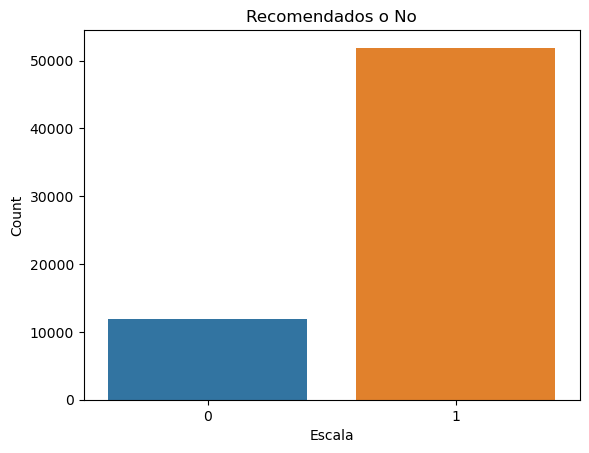

In [431]:
# Visualizar
sns.countplot(data=total_reviews, x='Recomendado_binario')
plt.xlabel('Escala')
plt.ylabel('Count')
plt.title('Recomendados o No')
plt.show()

In [442]:
total_reviews["Recomendado_binario"].value_counts()

1    51898
0    11952
Name: Recomendado_binario, dtype: int64

In [446]:
#Cuento cantidad de comentarios

total_reviews_p=total_reviews[total_reviews['Recomendado_binario']==1]
total_reviews_n=total_reviews[total_reviews['Recomendado_binario']==0]
len(total_reviews_p), len(total_reviews_n)

(51898, 11952)

In [447]:
#Selecciono la misma cantidad de comentarios positivos y negativos

datap = total_reviews_p.iloc[np.random.randint(0, len(total_reviews_p), 10000), :]
datan = total_reviews_n.iloc[np.random.randint(0, len(total_reviews_n), 10000), :]

len(datan), len(datap)

(10000, 10000)

In [448]:
train = pd.concat([datan, datap])

In [450]:
train.drop(columns = "_id", inplace= True)

In [458]:
train.reset_index(drop=True, inplace=True)

In [459]:
train

,Contenido,Valoración,Recomendado_binario
0,empieza dar vueltas cama personaje puedo usar ...,No recomendado,0
1,look ive played games for about 25 years and a...,No recomendado,0
2,9 enero read the reviews about the game not la...,No recomendado,0
3,puedo iniciarlo logre solucionar errores antic...,No recomendado,0
4,19 febrero suicide is better option then playi...,No recomendado,0
...,...,...,...
19995,buenisimo,Recomendado,1
19996,gyobu masataka oniwa,Recomendado,1
19997,i mean the game is just amazing nothing to add...,Recomendado,1
19998,ta weno,Recomendado,1
